In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualizationdf_e.shape
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
# Load the dataset
df_e = pd.read_csv('../data/processed/additional_data.csv')


In [3]:
import warnings
warnings.filterwarnings("ignore")


#### Remove outliers

#### 1. Price

<Axes: xlabel='price', ylabel='Count'>

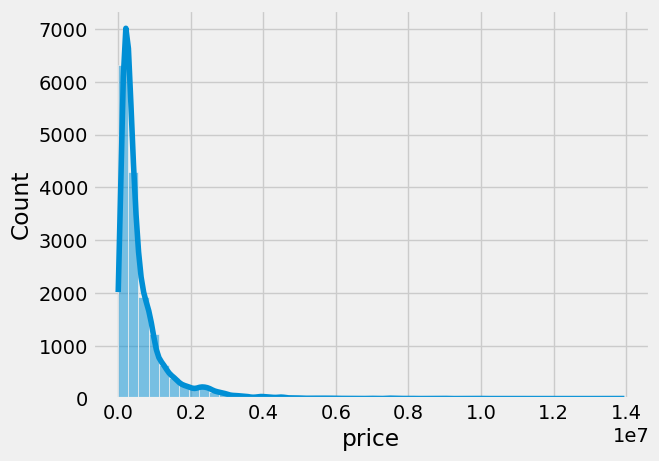

In [4]:
sns.histplot(df_e['price'],kde = True,bins=50)

<Axes: xlabel='price', ylabel='Count'>

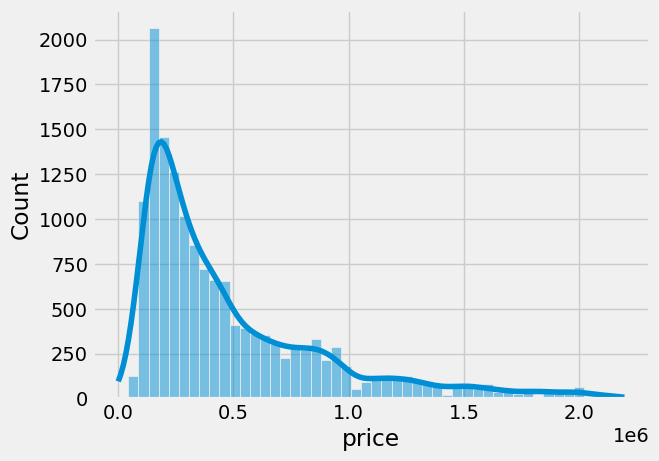

In [5]:

q = df_e['price'].quantile(0.95)

df_e = df_e[df_e['price']<q]

sns.histplot(df_e['price'],kde = True,bins=50)

#### 2. Rooms

<Axes: xlabel='rooms', ylabel='Count'>

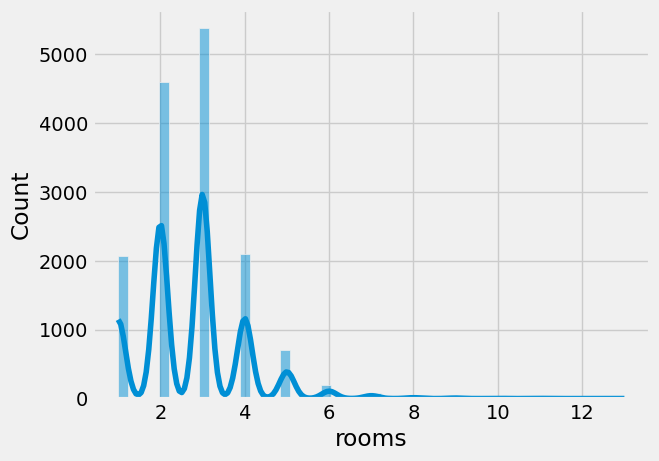

In [6]:
sns.histplot(df_e['rooms'],kde = True,bins=50)

<Axes: xlabel='rooms', ylabel='Count'>

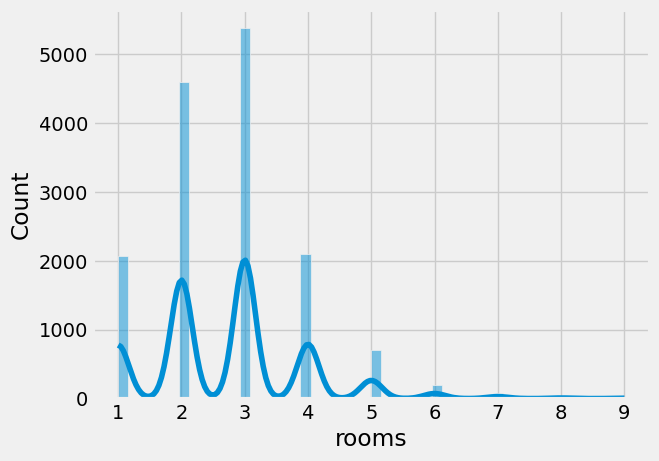

In [7]:

df_e = df_e[df_e['rooms']<10]

sns.histplot(df_e['rooms'],kde = True,bins=50)

#### 3. Area (m2)

<Axes: xlabel='m2', ylabel='Count'>

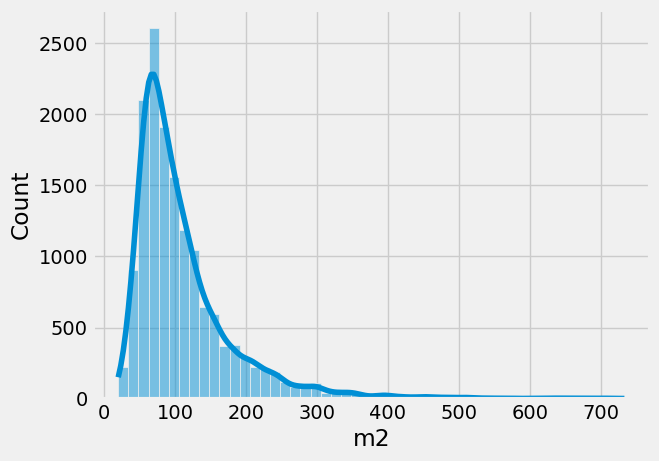

In [8]:
sns.histplot(df_e['m2'], kde = True, bins = 50)

<Axes: xlabel='m2', ylabel='Count'>

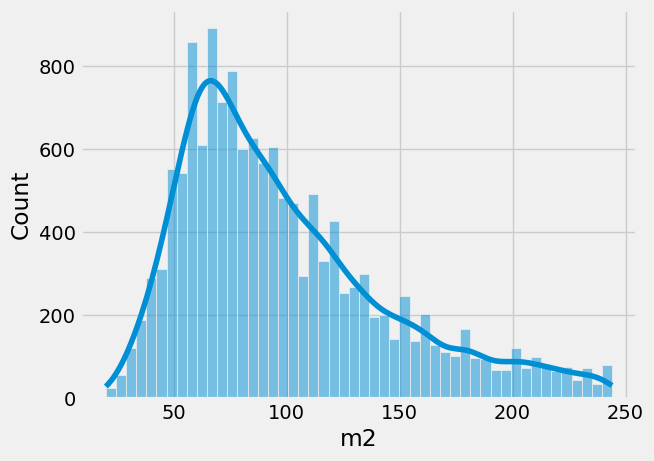

In [9]:
q = df_e['m2'].quantile(0.95)

df_e = df_e[df_e['m2']<q]

sns.histplot(df_e['m2'],kde = True,bins=50)

#### Data Cleaning

In [10]:
df_e_without_duplicates = df_e.drop_duplicates()

In [11]:
df_e_without_duplicates.isna().sum()

price             0
house_type        0
house_type_2    449
rooms             0
m2                0
elevator          0
garage            0
neighborhood      0
district          0
dtype: int64

In [12]:
df_e_without_duplicates_without_na = df_e_without_duplicates.dropna()

In [13]:
df_e_without_duplicates_without_na.isna().sum()

price           0
house_type      0
house_type_2    0
rooms           0
m2              0
elevator        0
garage          0
neighborhood    0
district        0
dtype: int64

In [14]:
df_e_without_duplicates_without_na.shape

(12391, 9)

In [17]:
df = df_e_without_duplicates_without_na

In [18]:
# Create the new columns
df['house_type_'] = df['house_type']
df['floor'] = 'n/a'

In [20]:
import re
# Function to categorize house_type_ and floor
def categorize_house_type(house_type):
    match = re.match(r'^planta\s*(-?\d+)$', house_type)
    if match:
        return 'Apartment', match.group(1)
    else:
        return house_type, 'n/a'

# Apply the function to the DataFrame and create new columns
df[['house_type_', 'floor']] = df['house_type'].apply(lambda x: pd.Series(categorize_house_type(x)))

print(df)

        price house_type house_type_2  rooms     m2  elevator  garage  \
0      495000   planta 1     exterior      3  118.0      True    True   
1      485000   planta 2     exterior      2   82.0      True    True   
2      315000   planta 2     exterior      2   72.0     False   False   
3      585000   planta 4     exterior      2  174.0      True    True   
4      255000       bajo     exterior      3   75.0     False   False   
...       ...        ...          ...    ...    ...       ...     ...   
15969  380000   planta 5     exterior      3   90.0      True    True   
15971  108000   planta 3     exterior      3   60.0     False   False   
15972  140000       bajo     exterior      2   65.0     False   False   
15973  135000   planta 1     exterior      2   71.0     False   False   
15974  150000   planta 4     exterior      4   71.0      True   False   

          neighborhood    district house_type_ floor  
0              Chopera  Arganzuela   Apartment     1  
1      Palos 

In [21]:
df['house_type_'].value_counts()

house_type_
Apartment      10223
bajo            1724
entreplanta      210
chalet            77
semi-sotano       72
casa              55
sotano            30
Name: count, dtype: int64

In [22]:
df.drop(columns=['house_type'], inplace=True)

In [23]:
df['floor'].replace('n/a','0',inplace=True)

In [24]:
df['floor'].value_counts()

floor
1     2592
2     2205
0     2168
3     1901
4     1378
5      833
6      497
7      310
8      173
9      118
10      69
11      42
13      33
12      27
-1      13
14      10
15       7
18       5
16       4
20       4
19       2
Name: count, dtype: int64

In [25]:
# Convert 'floor' column to numeric, setting errors='coerce' to handle invalid values
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')

print(df['floor'].dtype)  # This should now print 'int64'


int64


In [26]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
df[numeric_cols].corr()['price'].sort_values(ascending=False)

price    1.000000
m2       0.792947
rooms    0.404496
floor    0.222657
Name: price, dtype: float64

In [27]:
#conda install -c conda-forge pycaret

In [28]:
from pycaret.regression import *

In [29]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    #test_data=test_data,
    target = 'price',
    session_id=9,
    ignore_features=[],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore'
    )

,Description,Value
0,Session id,9
1,Target,price
2,Target type,Regression
3,Original data shape,"(12391, 10)"
4,Transformed data shape,"(12391, 36)"
5,Transformed train set shape,"(8673, 36)"
6,Transformed test set shape,"(3718, 36)"
7,Numeric features,3
8,Categorical features,4
9,Preprocess,True


In [30]:
# compare baseline models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,71664.6824,14401022641.3672,119902.7984,0.8811,0.2227,0.2002,0.3100
et,Extra Trees Regressor,70397.8047,15053002668.5883,122571.5297,0.8758,0.2248,0.1933,0.2830
rf,Random Forest Regressor,71760.1276,15114668478.6669,122807.4766,0.8750,0.2264,0.2004,0.3120
gbr,Gradient Boosting Regressor,79040.0956,16626025730.2415,128813.3915,0.8628,0.2440,0.2224,0.1430
knn,K Neighbors Regressor,87053.2942,21122676835.6819,145158.0525,0.8260,0.2636,0.2294,0.0550
dt,Decision Tree Regressor,93433.7532,26863211189.9231,163720.1719,0.7781,0.3040,0.2357,0.0510
ridge,Ridge Regression,116940.5082,28958269391.9462,170033.5782,0.7612,0.6292,0.3909,0.0460
llar,Lasso Least Angle Regression,116947.6384,28958377759.4827,170033.9693,0.7612,0.6309,0.3910,0.0460
br,Bayesian Ridge,116836.3180,28957519041.4757,170030.3103,0.7612,0.6192,0.3901,0.0480
lasso,Lasso Regression,116947.6526,28958372090.2995,170033.9528,0.7612,0.6310,0.3910,0.1160


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [31]:
# predict on test set
holdout_pred = predict_model(best_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,69730.9416,13727192485.5641,117163.1021,0.8745,0.2147,0.1700


In [32]:
# show predictions df
holdout_pred[['price','prediction_label']].head()

,price,prediction_label
4022,575000,5.441791e+05
5080,435000,5.495393e+05
5890,1595000,1.512469e+06
1599,430000,3.581119e+05
7910,726000,7.904451e+05
